In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')

In [5]:
df = df[['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income',
'median_house_value','ocean_proximity']]

In [6]:
df.fillna(0, inplace = True)

In [7]:
df.isnull().sum()

latitude              0
longitude             0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [8]:
df['median_house_value'] = np.log(df.median_house_value.values) 

Do train/validation/test split with 60%/20%/20% distribution.

Use the train_test_split function and set the random_state parameter to 1.

In [9]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [13]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [11]:
train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
x_train = dv.fit_transform(train_dicts)

In [12]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
x_val = dv.transform(val_dicts)

Let's train a decision tree regressor to predict the median_house_value variable

Train a model with max_depth=1
Which feature is used for splitting the data?

ocean_proximity=INLAND
total_rooms
latitude
population

In [15]:
regressor = DecisionTreeRegressor(random_state=1, max_depth = 1)
regressor.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=1, random_state=1)

In [26]:
from sklearn.tree import export_text
print(export_text(regressor, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Train a random forest model with these parameters:

What's the RMSE of this model on validation?

In [30]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(x_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [31]:
from sklearn.metrics import mean_squared_error
y_pred = rf.predict(x_val)
print(np.sqrt(mean_squared_error(y_val, y_pred)))

0.24535889106760073


Now let's experiment with the n_estimators parameter

Try different values of this parameter from 10 to 200 with step 10.
Set random_state to 1.
Evaluate the model on the validation dataset.
After which value of n_estimators does RMSE stop improving?

  0%|          | 0/20 [00:00<?, ?it/s]

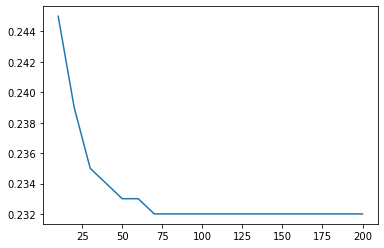

In [32]:
from tqdm.auto import tqdm

res = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(x_train, y_train)
    
    y_pred = rf.predict(x_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    res.append((n, score))

scores = pd.DataFrame(res, columns=['n_estimators', 'rmse'])

plt.plot(scores.n_estimators, scores.rmse.round(3))

Let's select the best max_depth:

Try different values of max_depth: [10, 15, 20, 25]
For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
Fix the random seed: random_state=1
What's the best max_depth:

In [33]:
res = []

for d in tqdm([10, 15, 20, 25]):
    for n in tqdm(range(10, 201, 10)):
        rf = RandomForestRegressor(n_estimators=n,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        res.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
scores = pd.DataFrame(res, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

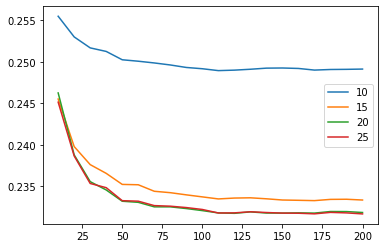

In [34]:
for d in [10, 15, 20, 25]:
    select = scores[scores.max_depth == d]
    plt.plot(select.n_estimators, select.rmse, label=d)

plt.legend()

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.
For this homework question, we'll find the most important feature:

Train the model with these parametes:
n_estimators=10,
max_depth=20,
random_state=1,
n_jobs=-1 (optional)
Get the feature importance information from this model
What's the most important feature?

In [35]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [36]:
rf.feature_importances_

array([1.68877189e-02, 3.29234611e-02, 1.00635995e-01, 9.68727768e-02,
       3.63889951e-01, 3.06679246e-03, 3.10901161e-01, 3.58566277e-04,
       2.70076860e-04, 4.21955925e-03, 3.00099243e-02, 1.90503564e-02,
       2.09136608e-02])

In [37]:
importances = pd.DataFrame()
importances['feature'] = dv.get_feature_names()
importances['importance'] = rf.feature_importances_
importances

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
0,households,0.016888
1,housing_median_age,0.032923
2,latitude,0.100636
3,longitude,0.096873
4,median_income,0.363890
5,ocean_proximity=<1H OCEAN,0.003067
6,ocean_proximity=INLAND,0.310901
7,ocean_proximity=ISLAND,0.000359
8,ocean_proximity=NEAR BAY,0.000270
9,ocean_proximity=NEAR OCEAN,0.004220


Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

Install XGBoost
Create DMatrix for train and validation
Create a watchlist
Train a model with these parameters for 100 rounds:

xgb_params = {'eta': 0.3, 'max_depth': 6,
    'min_child_weight': 1, 'objective': 'reg:squarederror',
    'nthread': 8,'seed': 1,'verbosity': 1}
    
Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

In [40]:
!pip install xgboost

In [41]:
import xgboost as xgb

In [45]:
features = dv.feature_names_

import re

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

train = xgb.DMatrix(x_train, label=y_train, feature_names=features)
val = xgb.DMatrix(x_val, label=y_val, feature_names=features)

In [46]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'eval_metric':'rmse',
    'seed': 1,
    'verbosity': 1,
}

watch_list = [(train, 'train'),(val, 'val')]

xgb_model = xgb.train(xgb_params ,train, num_boost_round=100, evals=watch_list, verbose_eval=10)

[0]	train-rmse:8.12733	val-rmse:8.13244
[10]	train-rmse:0.34481	val-rmse:0.35782
[20]	train-rmse:0.21461	val-rmse:0.24532
[30]	train-rmse:0.19462	val-rmse:0.23694
[40]	train-rmse:0.18073	val-rmse:0.23358
[50]	train-rmse:0.17133	val-rmse:0.23297
[60]	train-rmse:0.16016	val-rmse:0.23109
[70]	train-rmse:0.15374	val-rmse:0.23070
[80]	train-rmse:0.14708	val-rmse:0.22903
[90]	train-rmse:0.14010	val-rmse:0.22856
[99]	train-rmse:0.13522	val-rmse:0.22784


In [47]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'eval_metric':'rmse',
    'seed': 1,
    'verbosity': 1,
}

watch_list = [(train, 'train'),(val, 'val')]

xgb_model = xgb.train(xgb_params ,train, num_boost_round=100, evals=watch_list, verbose_eval=10)

[0]	train-rmse:10.44371	val-rmse:10.44937
[10]	train-rmse:3.65747	val-rmse:3.66144
[20]	train-rmse:1.30614	val-rmse:1.31096
[30]	train-rmse:0.51253	val-rmse:0.52303
[40]	train-rmse:0.27985	val-rmse:0.30045
[50]	train-rmse:0.22580	val-rmse:0.25398
[60]	train-rmse:0.21000	val-rmse:0.24224
[70]	train-rmse:0.20225	val-rmse:0.23893
[80]	train-rmse:0.19554	val-rmse:0.23622
[90]	train-rmse:0.18863	val-rmse:0.23364
[99]	train-rmse:0.18415	val-rmse:0.23245
